# Global search using Lookup Table
## Synthetic model with 2 layers

In [1]:
%matplotlib widget

In [2]:
# Import libraries
import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
#from mpl_toolkits import mplot3d
import pandas as pd

#import tensorflow_docs as tfdocs
#import tensorflow_docs.modeling
#import tensorflow_docs.plots

import sys
sys.path.insert(1, '../src')

from PlotModel import PlotModelCond_2lay, Plot3Models_2lay, PlotErrorSpace, PlotData, rmse_a
from EM1D import EMforward2lay, GlobalSearch, ErrorSpace

### 1. Define the synthetic model

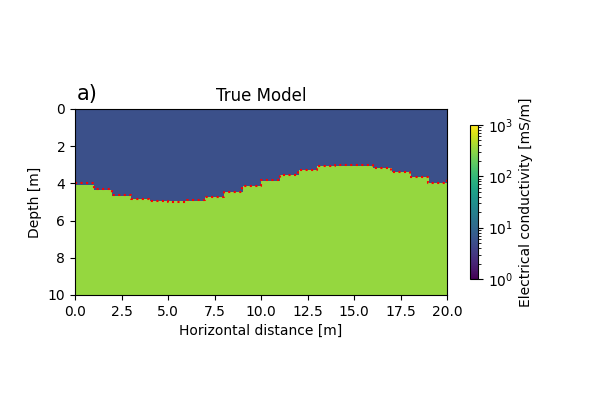

In [80]:
# Import the conductivities and thicknesses used to create the LU table

conds = np.load('../data/conds_samples.npy')
thick = np.load('../data/thick_samples.npy')

# parameters for the synthetic model

nlayer = 2 # number of layer
npos = 20 # number of sampling positions

sig_ini = [conds[14]-conds[3], conds[42]+conds[3]] # conductivities of the layers
sigmas = np.ones((npos, nlayer))*sig_ini # conductivity array

x = np.linspace(0, 20, npos) # Horizontal positions array
thk1 = np.ones_like(x)*4 + np.sin(2*np.pi*x)   # wave boundary for the layers
#thk1[10:] -= 2.5

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1 

PlotModelCond_2lay(sigmas, depths, depths)
plt.title('True Model')
plt.text(0.1,-0.5,'a)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
plt.savefig('../figures/TrueModel_2Lay_flip')

### 2. Create synthetic data to test the global search

In [81]:
# Create empty array for true model in each position
model = np.stack((sigmas[:,0], sigmas[:,1], depths[:,1]), axis=1)

# Create empty array for true data in each position
data_true=[]

# Simulate data in each position
for i in range(npos):
    data_true.append(EMforward2lay(sigmas[i][0], sigmas[i][1], depths[i][1], height = 0.10)) 
    
data_true = np.array(data_true)

In [82]:
np.save('../data/data_true_flip', data_true)
np.save('../data/model_true_flip', model)

### 3. Normalize data sets due to offset

In [83]:
LUT = np.load('../data/LookupTable2Layers.npy')

#norm = np.array([4, 2, 1])

#LUT_norm = LUT[:] * np.hstack([norm, norm, norm, norm, norm, norm])
#data_true_norm = data_true[:] * np.hstack([norm, norm, norm, norm, norm, norm])

### 3. Perform global search in each position

In [84]:
model_est = model.copy()
model_est_Q = model.copy()
model_est_IP = model.copy()

#LUT_norm_slice = LUT_norm[:,:15].copy()
#LUT_norm_slice[:,:9] = LUT_norm[:,:9]
#LUT_norm_slice[:,9:] = LUT_norm[:,12:]

#data_true_norm_slice = data_true_norm[:,:15].copy()
#data_true_norm_slice[:,9:] = data_true_norm[:,12:]

# Estimate with both Quadrature and In Phase
for p in range(npos):
    #model_est[p] = GlobalSearch(LUT_norm_slice, data_true_norm_slice[p], conds, thick)
    model_est[p] = GlobalSearch(LUT, data_true[p], conds, thick)
    
# Estimate using only Quadrature
for p in range(npos):
    #model_est_Q[p] = GlobalSearch(LUT_norm[:,:9], data_true_norm[p,:9], conds, thick)
    model_est_Q[p] = GlobalSearch(LUT[:,:9], data_true[p,:9], conds, thick)
    
# Estimate using only In Phase
for p in range(npos):
    #model_est_IP[p] = GlobalSearch(LUT_norm[:,12:], data_true_norm[p,12:], conds, thick)
    model_est_IP[p] = GlobalSearch(LUT[:,12:], data_true[p,12:], conds, thick)

In [85]:
np.save('../data/model_est_flip', model_est)
np.save('../data/model_est_Q_flip', model_est_Q)
np.save('../data/model_est_IP_flip', model_est_IP)

### 4. Plot Estimated model

In [86]:
#Plot3Models_2lay(model, model_est, model_est_Q, conds)
#plt.show()

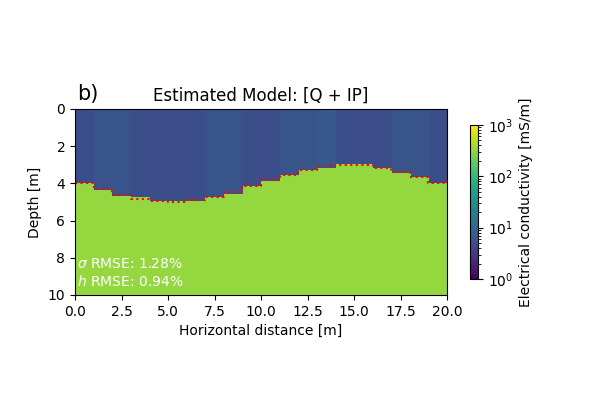

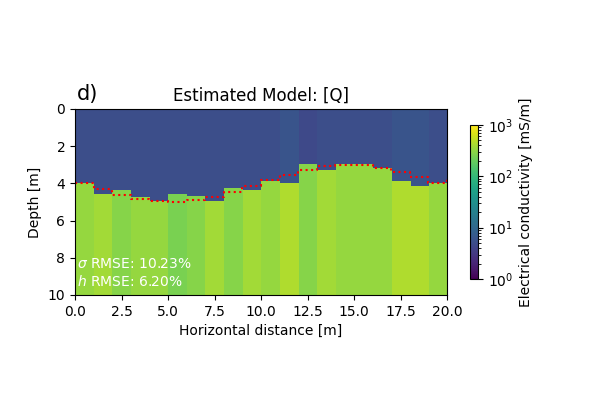

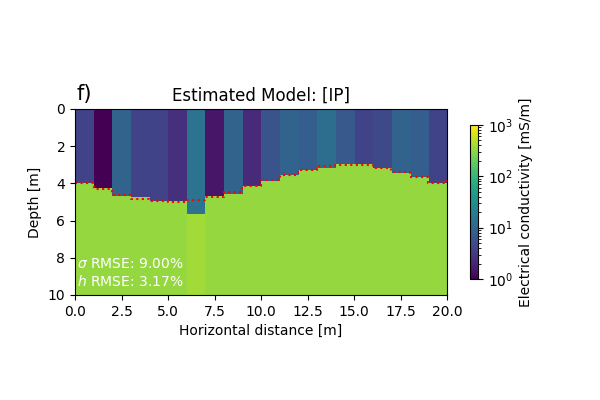

In [87]:
sigmas_est = model_est[:,:2]
depths_est = depths.copy()
depths_est[:,1] = model_est[:,2]

sigmas_est_Q = model_est_Q[:,:2]
depths_est_Q = depths.copy()
depths_est_Q[:,1] = model_est_Q[:,2]

sigmas_est_IP = model_est_IP[:,:2]
depths_est_IP = depths.copy()
depths_est_IP[:,1] = model_est_IP[:,2]

PlotModelCond_2lay(sigmas_est, depths_est, depth_true=depths)
plt.title('Estimated Model: [Q + IP]')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est[:,1])*100)+'%', color='w',fontsize=10)
plt.text(0.1,-0.5,'b)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
plt.savefig('../figures/GS_EstModel_Q+IP_2Lay_flip')

PlotModelCond_2lay(sigmas_est_Q, depths_est_Q, depth_true =depths)
plt.title('Estimated Model: [Q]')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_Q)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_Q[:,1])*100)+'%', color='w',fontsize=10)
plt.text(0.1,-0.5,'d)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
plt.savefig('../figures/GS_EstModel_Q_2Lay_flip')

PlotModelCond_2lay(sigmas_est_IP, depths_est_IP, depth_true=depths)
plt.title('Estimated Model: [IP]')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_IP)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_IP[:,1])*100)+'%', color='w',fontsize=10)
plt.text(0.1,-0.5,'f)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
plt.savefig('../figures/GS_EstModel_IP_2Lay_flip')

### 5. Check the error space in a specific position

In [ ]:
# For example let's check the following position
pos = 10

# Simulate data for this position
data_est_pos = EMforward2lay(model_est[pos,0], model_est[pos,1], model_est[pos,2], height=0.1)
#data_est_pos_norm = data_est_pos * np.hstack([norm, norm, norm, norm, norm, norm])

data_estQ_pos = EMforward2lay(model_est_Q[pos,0], model_est_Q[pos,1], model_est_Q[pos,2], height=0.1)
#data_estQ_pos_norm = data_estQ_pos * np.hstack([norm, norm, norm, norm, norm, norm])

data_estIP_pos = EMforward2lay(model_est_IP[pos,0], model_est_IP[pos,1], model_est_IP[pos,2], height=0.1)
#data_estIP_pos_norm = data_estIP_pos * np.hstack([norm, norm, norm, norm, norm, norm])

# Evaluate error space
#err, models_err = ErrorSpace(LUT_norm, data_est_pos_norm, 0.1, conds, thick)
#err_Q, models_err_Q = ErrorSpace(LUT_norm, data_estQ_pos_norm, 0.1, conds, thick)
#err_IP, models_err_IP = ErrorSpace(LUT_norm, data_estIP_pos_norm, 0.1, conds, thick)
err, models_err = ErrorSpace(LUT, data_est_pos, 0.1, conds, thick)
err_Q, models_err_Q = ErrorSpace(LUT, data_estQ_pos, 0.1, conds, thick)
err_IP, models_err_IP = ErrorSpace(LUT, data_estIP_pos, 0.1, conds, thick)

In [ ]:
# Error space using Q + IP

PlotErrorSpace(model, model_est, pos, err, models_err)
plt.tight_layout()
plt.show()
plt.savefig('../figures/error_space')

In [ ]:
# Error space using Q 
PlotErrorSpace(model, model_est_Q, pos, err_Q, models_err_Q)
plt.tight_layout()
plt.show()
plt.savefig('../figures/error_space_Q')

In [ ]:
# Error space using Q 
PlotErrorSpace(model, model_est_IP, pos, err_IP, models_err_IP)
plt.tight_layout()
plt.show()
plt.savefig('../figures/error_space_IP')

In [104]:
## Let's test the Global search with noise added to data

# Adding noise to data
error = 0.1

data_true_noise_Q = data_true[:,:9].copy()
data_true_noise_IP = data_true[:,9:].copy()

data_true_noise_Q *= np.random.randn(np.size(data_true_noise_Q)).reshape(np.shape(data_true_noise_Q))*error+1
data_true_noise_IP *= np.random.randn(np.size(data_true_noise_IP)).reshape(np.shape(data_true_noise_IP))*error+1
#data_true_noise *= np.random.normal(0.0, 0.04, size=np.shape(data_true))+1
#data_true_noise *= np.random.randn(np.size(data_true)).reshape(np.shape(data_true))*error+1

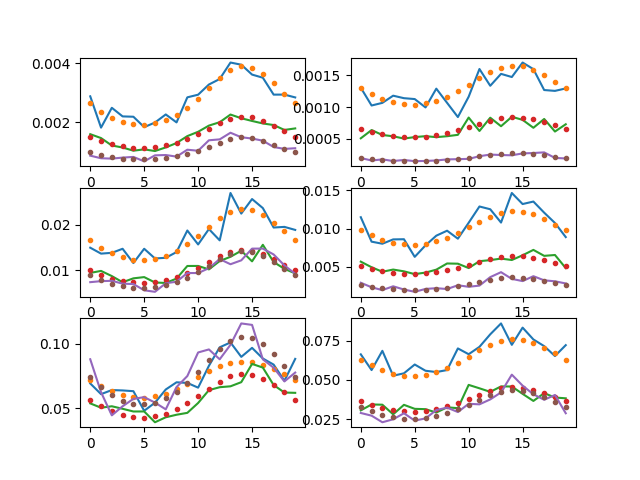

In [105]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(data_true_noise_Q[:,0])
ax[0,0].plot(data_true[:,0], '.')
ax[0,0].plot(data_true_noise_Q[:,3])
ax[0,0].plot(data_true[:,3], '.')
ax[0,0].plot(data_true_noise_Q[:,6])
ax[0,0].plot(data_true[:,6], '.')

ax[1,0].plot(data_true_noise_Q[:,1])
ax[1,0].plot(data_true[:,1], '.')
ax[1,0].plot(data_true_noise_Q[:,4])
ax[1,0].plot(data_true[:,4], '.')
ax[1,0].plot(data_true_noise_Q[:,7])
ax[1,0].plot(data_true[:,7], '.')

ax[2,0].plot(data_true_noise_Q[:,2])
ax[2,0].plot(data_true[:,2], '.')
ax[2,0].plot(data_true_noise_Q[:,5])
ax[2,0].plot(data_true[:,5], '.')
ax[2,0].plot(data_true_noise_Q[:,8])
ax[2,0].plot(data_true[:,8], '.')

ax[0,1].plot(data_true_noise_IP[:,0])
ax[0,1].plot(data_true[:,9], '.')
ax[0,1].plot(data_true_noise_IP[:,3])
ax[0,1].plot(data_true[:,12], '.')
ax[0,1].plot(data_true_noise_IP[:,6])
ax[0,1].plot(data_true[:,15], '.')

ax[1,1].plot(data_true_noise_IP[:,1])
ax[1,1].plot(data_true[:,10], '.')
ax[1,1].plot(data_true_noise_IP[:,4])
ax[1,1].plot(data_true[:,13], '.')
ax[1,1].plot(data_true_noise_IP[:,7])
ax[1,1].plot(data_true[:,16], '.')

ax[2,1].plot(data_true_noise_IP[:,2])
ax[2,1].plot(data_true[:,11], '.')
ax[2,1].plot(data_true_noise_IP[:,5])
ax[2,1].plot(data_true[:,14], '.')
ax[2,1].plot(data_true_noise_IP[:,8])
ax[2,1].plot(data_true[:,17], '.')

In [106]:
data_true_noise = data_true.copy()
data_true_noise[:,:9] = data_true_noise_Q
data_true_noise[:,9:] = data_true_noise_IP

np.save('../data/data_true_noise_10_flip', data_true_noise)

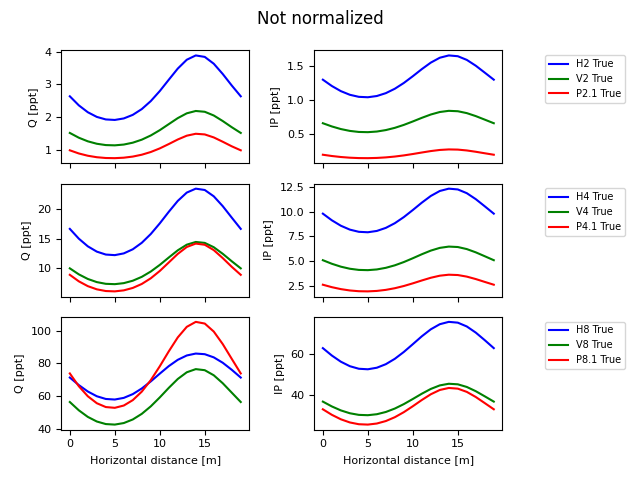

In [107]:
fig, ax = plt.subplots(3,2, sharex=True)
PlotData(data_true, ax=ax)
#PlotData(data_true_noise, ax=ax)
fig.suptitle('Not normalized')
plt.tight_layout()

In [108]:
#data_true_norm_noise = data_true_noise[:] * np.hstack([norm, norm, norm, norm, norm, norm])

model_est_noise = model.copy()
model_est_Q_noise = model.copy()
model_est_IP_noise = model.copy()

#LUT_norm_slice = LUT_norm[:,:15].copy()
#LUT_norm_slice[:,:9] = LUT_norm[:,:9]
#LUT_norm_slice[:,9:] = LUT_norm[:,12:]

#data_true_norm_noise_slice = data_true_norm_noise[:,:15].copy()
#data_true_norm_noise_slice[:,9:] = data_true_norm_noise[:,12:]

# Estimate with both Quadrature and In Phase
for p in range(npos):
    #model_est_noise[p] = GlobalSearch(LUT_norm_slice, data_true_norm_noise_slice[p], conds, thick)
    model_est_noise[p] = GlobalSearch(LUT, data_true_noise[p], conds, thick)
    
# Estimate using only Quadrature
for p in range(npos):
    #model_est_Q_noise[p] = GlobalSearch(LUT_norm[:,:9], data_true_norm_noise[p,:9], conds, thick)
    model_est_Q_noise[p] = GlobalSearch(LUT[:,:9], data_true_noise_Q[p,:], conds, thick)
    
# Estimate using only Quadrature
for p in range(npos):
    #model_est_IP_noise[p] = GlobalSearch(LUT_norm[:,9:], data_true_norm_noise[p,9:], conds, thick)
    model_est_IP_noise[p] = GlobalSearch(LUT[:,9:], data_true_noise_IP[p,:], conds, thick)

In [36]:
#fig, ax = plt.subplots(3,2, sharex=True)
#PlotData(data_true_norm, ax=ax)
#PlotData(data_true_norm_noise, ax=ax)
#fig.suptitle('Normalized')
#plt.tight_layout()

In [109]:
np.save('../data/model_est_noise_10_flip', model_est_noise)
np.save('../data/model_est_Q_noise_10_flip', model_est_Q_noise)
np.save('../data/model_est_IP_noise_10_flip', model_est_IP_noise)

In [110]:
#Plot3Models_2lay(model, model_est_noise, model_est_Q_noise, conds)
#plt.show()

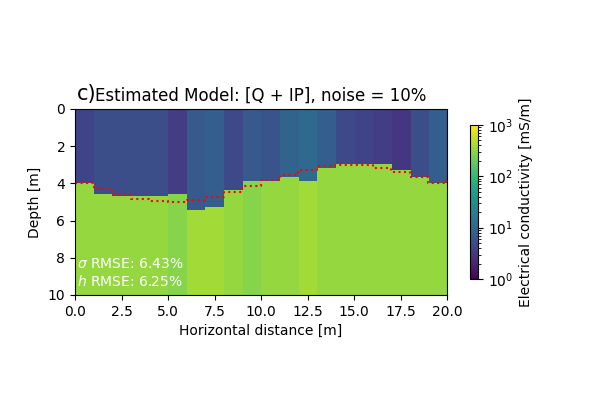

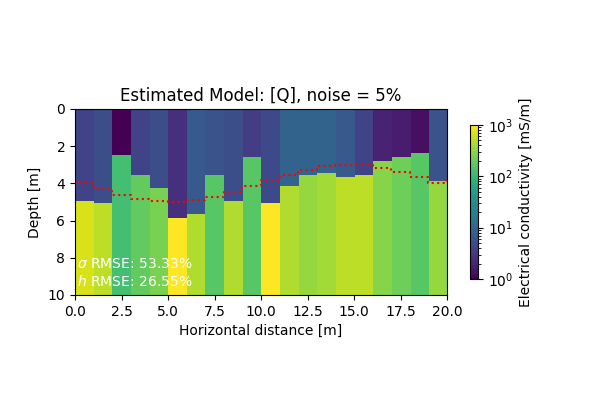

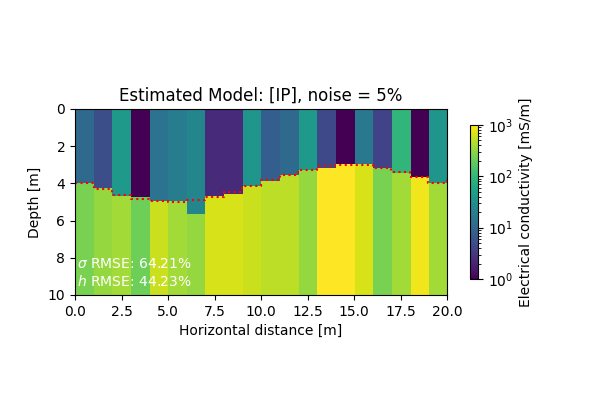

In [111]:
sigmas_est_noise = model_est_noise[:,:2]
depths_est_noise = depths.copy()
depths_est_noise[:,1] = model_est_noise[:,2]

sigmas_est_Q_noise = model_est_Q_noise[:,:2]
depths_est_Q_noise = depths.copy()
depths_est_Q_noise[:,1] = model_est_Q_noise[:,2]

sigmas_est_IP_noise = model_est_IP_noise[:,:2]
depths_est_IP_noise = depths.copy()
depths_est_IP_noise[:,1] = model_est_IP_noise[:,2]

PlotModelCond_2lay(sigmas_est_noise, depths_est_noise, depths)
plt.title('Estimated Model: [Q + IP], noise = 10%')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_noise)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_noise[:,1])*100)+'%', color='w',fontsize=10)
plt.text(0.1,-0.5,'c)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
plt.savefig('../figures/GS_EstModel_Q+IP_2Lay_noise10_flip')

PlotModelCond_2lay(sigmas_est_Q_noise, depths_est_Q_noise, depths)
plt.title('Estimated Model: [Q], noise = 5%')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_Q_noise)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_Q_noise[:,1])*100)+'%', color='w',fontsize=10)
plt.show()

PlotModelCond_2lay(sigmas_est_IP_noise, depths_est_IP, depths)
plt.title('Estimated Model: [IP], noise = 5%')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_IP_noise)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_IP_noise[:,1])*100)+'%', color='w',fontsize=10)
plt.show()